#imports

In [ ]:
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import cv2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix
# import ipywidgets as widgets
# import io
# from PIL import Image
# from IPython.display import display,clear_output
# from warnings import filterwarnings
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
url = 'https://drive.google.com/file/d/1NoFMHIxakb78GRXp6LaiY2Wwyb9TxU-I'
gdd.download_file_from_google_drive(
    url.split('/')[-1], './kaggle.json')

In [ ]:
%pip install -q kaggle

In [ ]:
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!cp kaggle.json /root/.kaggle

In [ ]:
!kaggle datasets list -s SARTAJ

ref                                           title                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------  --------------------------------  -----  -------------------  -------------  ---------  ---------------  
sartajbhuvaji/brain-tumor-classification-mri  Brain Tumor Classification (MRI)   87MB  2020-05-24 16:24:55          14934        309  0.8125           
masoudnickparvar/brain-tumor-mri-dataset      Brain Tumor MRI Dataset           149MB  2021-09-24 12:43:45           3176         94  0.875            


In [ ]:
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri


brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!find Testing/ -type f -name '*.*' | sed 's|.*\.||' | sort -u

jpg


In [ ]:
!ls Testing/


glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


# dataset

In [ ]:
#for EfficientNetb4
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'Training',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.1,
    subset="training",
    seed=1907,
    labels='inferred',
    label_mode='categorical',
    )

Found 2870 files belonging to 4 classes.
Using 2583 files for training.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'Training',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.1,
    subset="validation",
    seed=1907,
    label_mode='categorical',
    )

Found 2870 files belonging to 4 classes.
Using 287 files for validation.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'Testing',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical',
    )

Found 394 files belonging to 4 classes.


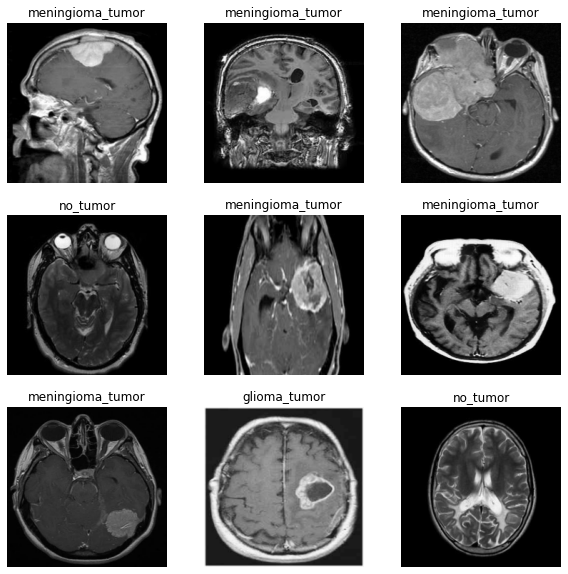

In [ ]:
# Retrieve a batch of images from the test set
class_names = train_dataset.class_names
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Apply an argmax since our model returns softmax
label_batch = tf.math.argmax(label_batch, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_batch[i]])
  plt.axis("off")

# Mobilenet

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

# Efficiantnet

In [ ]:
#preprocess_input = tf.keras.applications.efficientnet.preprocess_input
#rescale = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Create the base model from the pre-trained model EfficientNetB4
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

71696384/71686520 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1792)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
n_classes = 4
prediction_layer = tf.keras.layers.Dense(n_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = inputs
x = preprocess_input(inputs) 
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
initial_epochs = 40

loss0, accuracy0 = model.evaluate(validation_dataset)

9/9 [==============================] - 3s 92ms/step - loss: 1.6586 - accuracy: 0.3066


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.66
initial accuracy: 0.31


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
81/81 [==============================] - 9s 73ms/step - loss: 1.3800 - accuracy: 0.4019 - val_loss: 1.0923 - val_accuracy: 0.5784
Epoch 2/30
81/81 [==============================] - 6s 68ms/step - loss: 1.0928 - accuracy: 0.5408 - val_loss: 0.9113 - val_accuracy: 0.6794
Epoch 3/30
81/81 [==============================] - 6s 67ms/step - loss: 0.9298 - accuracy: 0.6276 - val_loss: 0.8002 - val_accuracy: 0.7038
Epoch 4/30
81/81 [==============================] - 6s 69ms/step - loss: 0.8327 - accuracy: 0.6709 - val_loss: 0.7288 - val_accuracy: 0.7422
Epoch 5/30
81/81 [==============================] - 6s 68ms/step - loss: 0.7497 - accuracy: 0.7154 - val_loss: 0.6800 - val_accuracy: 0.7596
Epoch 6/30
81/81 [==============================] - 6s 68ms/step - loss: 0.6948 - accuracy: 0.7356 - val_loss: 0.6384 - val_accuracy: 0.7700
Epoch 7/30
81/81 [==============================] - 6s 68ms/step - loss: 0.6560 - accuracy: 0.7480 - val_loss: 0.6172 - val_accuracy: 0.7700
Epoch 8/30
81

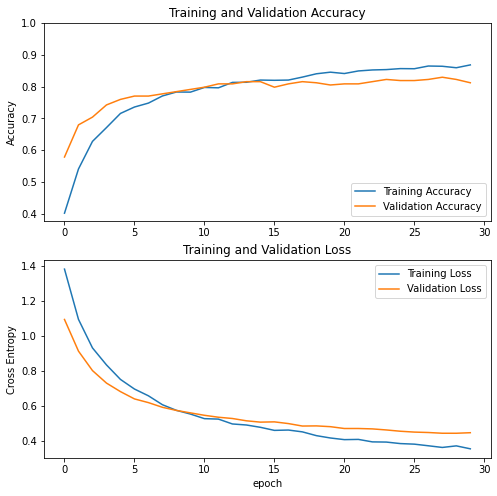

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10 #100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  474


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 17,469,028
Non-trainable params: 211,967
___________________________________________

In [ ]:
fine_tune_epochs = 2 #10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 3/5
81/81 [==============================] - 66s 504ms/step - loss: 0.6131 - accuracy: 0.7894 - val_loss: 0.5195 - val_accuracy: 0.8049
Epoch 4/5
81/81 [==============================] - 38s 468ms/step - loss: 0.3475 - accuracy: 0.8765 - val_loss: 0.4000 - val_accuracy: 0.8502
Epoch 5/5
81/81 [==============================] - 38s 461ms/step - loss: 0.2354 - accuracy: 0.9187 - val_loss: 0.3253 - val_accuracy: 0.8885


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

13/13 [==============================] - 3s 215ms/step - loss: 1.0314 - accuracy: 0.6929
Test accuracy : 0.692893385887146


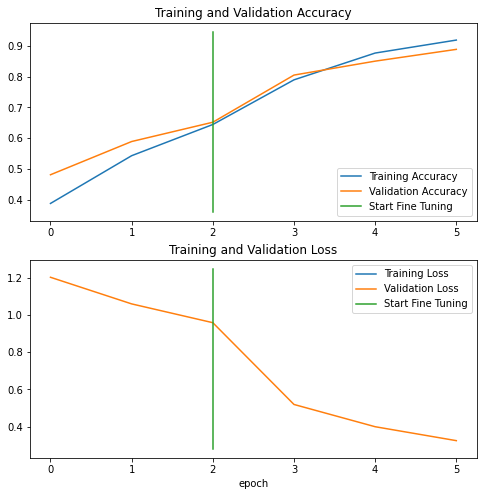

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

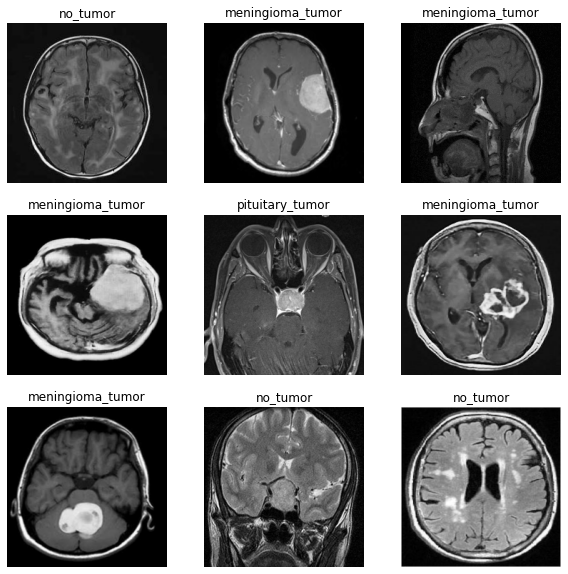

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply an argmax since our model returns softmax
predictions = tf.math.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
predicted_labels = model.predict(test_dataset)
len(predicted_labels)

394

In [ ]:
predicted_labels = [np.argmax(i) for i in predicted_labels]
print(predicted_labels)

[3, 2, 2, 1, 2, 2, 3, 1, 1, 2, 1, 0, 2, 2, 1, 3, 3, 2, 2, 1, 3, 1, 0, 2, 2, 1, 2, 3, 1, 1, 1, 0, 2, 1, 3, 2, 1, 2, 1, 0, 0, 1, 3, 1, 1, 1, 3, 2, 1, 2, 2, 3, 2, 0, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 3, 2, 0, 1, 2, 2, 3, 1, 1, 1, 3, 3, 2, 3, 1, 2, 3, 3, 1, 3, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 3, 2, 1, 1, 2, 2, 1, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 3, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 3, 1, 2, 2, 1, 1, 2, 2, 0, 2, 3, 1, 1, 1, 1, 0, 1, 2, 3, 1, 1, 1, 2, 0, 1, 2, 3, 2, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 2, 0, 1, 1, 3, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 1, 2, 1, 0, 3, 1, 1, 2, 2, 3, 3, 2, 3, 2, 2, 1, 3, 1, 3, 3, 0, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 1, 1, 0, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 0, 0, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 0, 2, 2, 1, 1, 

In [ ]:
test_label = np.concatenate([y for x, y in test_dataset], axis=0) 

In [ ]:
or_labels = [np.argmax(i) for i in test_label]
print(or_labels)

[0, 1, 0, 2, 2, 3, 2, 1, 1, 1, 1, 0, 2, 2, 2, 3, 2, 0, 3, 0, 1, 0, 0, 0, 1, 3, 3, 0, 3, 1, 1, 1, 0, 0, 2, 3, 3, 0, 2, 1, 2, 2, 2, 2, 0, 1, 3, 2, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2, 3, 3, 1, 0, 1, 3, 0, 0, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 3, 0, 0, 2, 1, 1, 0, 1, 3, 3, 2, 3, 3, 3, 2, 0, 1, 3, 2, 0, 0, 0, 3, 2, 1, 2, 1, 1, 0, 3, 3, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 1, 1, 1, 0, 3, 0, 3, 3, 0, 3, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 0, 3, 0, 0, 0, 1, 3, 2, 2, 3, 3, 1, 2, 1, 0, 1, 0, 3, 3, 0, 0, 2, 3, 3, 2, 2, 0, 2, 2, 1, 3, 1, 0, 1, 3, 0, 2, 1, 3, 0, 0, 3, 0, 1, 1, 1, 0, 2, 1, 2, 1, 0, 0, 2, 1, 3, 3, 2, 3, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 3, 0, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 3, 3, 0, 3, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 3, 0, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 3, 2, 1, 2, 0, 0, 0, 1, 3, 0, 1, 0, 3, 0, 1, 1, 3, 0, 3, 2, 1, 1, 2, 0, 0, 1, 2, 2, 3, 3, 3, 3, 0, 0, 1, 2, 2, 3, 2, 2, 2, 2, 0, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 0, 3, 0, 3, 2, 1, 0, 

In [ ]:
testClasses = test_dataset.class_names
testClasses

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
conf_mat = confusion_matrix(or_labels, predicted_labels)
report = classification_report(or_labels, predicted_labels)

print('Confusion Matrix ==>')
print(conf_mat)
print('----------------------------------------------------------------------------------------')
print('Classification Report ==>')
print(report)

Confusion Matrix ==>
[[13 52 24 11]
 [12 46 38 19]
 [ 6 42 35 22]
 [ 7 32 22 13]]
----------------------------------------------------------------------------------------
Classification Report ==>
              precision    recall  f1-score   support

           0       0.34      0.13      0.19       100
           1       0.27      0.40      0.32       115
           2       0.29      0.33      0.31       105
           3       0.20      0.18      0.19        74

    accuracy                           0.27       394
   macro avg       0.28      0.26      0.25       394
weighted avg       0.28      0.27      0.26       394



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

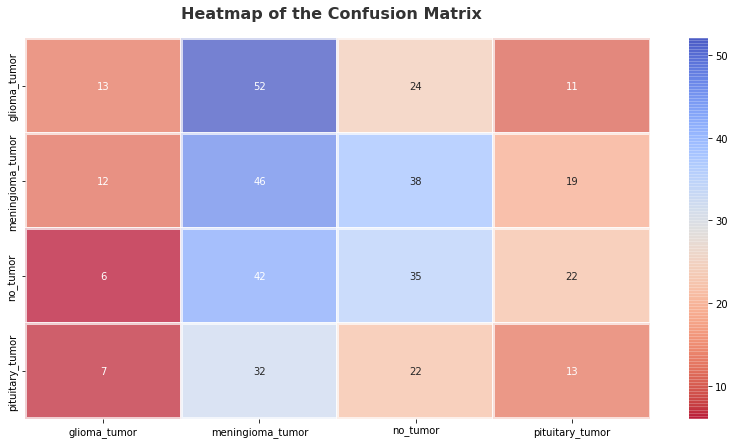

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(or_labels, predicted_labels),ax=ax,xticklabels=test_dataset.class_names,
            yticklabels=test_dataset.class_names,annot=True, 
            cmap="coolwarm_r",alpha=0.7,linewidths=2)

           
fig.text(s='Heatmap of the Confusion Matrix',size=16,fontweight='bold',
             y=0.92,x=0.28,alpha=0.8)

# split the data 

In [ ]:
labels=['glioma_tumor',  'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 161.99it/s]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1907,shuffle=True)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=1907,shuffle=True)

In [ ]:
len(y_train)

2643

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)



In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Create the base model from the pre-trained model EfficientNetB4
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1792)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
n_classes = 4
prediction_layer = tf.keras.layers.Dense(n_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs) #(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 7,172
Non-trainable params: 17,673,823
___________________________________________

In [ ]:
y_val.shape


(294, 4)

In [ ]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(X_val, y_val) #, batch_size=32, epochs=1,validation_data=(X_test,y_test),shuffle=False,verbose=2)

83/83 [==============================] - 18s 158ms/step - loss: 1.4639 - accuracy: 0.2327


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.46
initial accuracy: 0.23


In [ ]:
history = model.fit(X_train,y_train,
                    epochs=initial_epochs,
                    validation_data=(X_val, y_val))

Epoch 1/3
83/83 [==============================] - 94s 804ms/step - loss: 0.6596 - accuracy: 0.7666 - val_loss: 0.5698 - val_accuracy: 0.8061
Epoch 2/3
83/83 [==============================] - 62s 748ms/step - loss: 0.3877 - accuracy: 0.8683 - val_loss: 0.4410 - val_accuracy: 0.8503
Epoch 3/3
83/83 [==============================] - 63s 754ms/step - loss: 0.2691 - accuracy: 0.9084 - val_loss: 0.3589 - val_accuracy: 0.8741


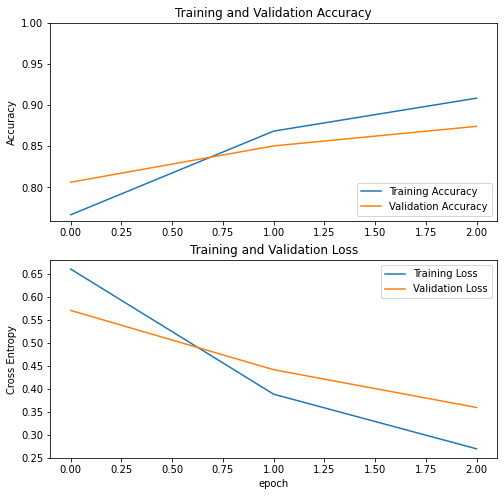

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10 #100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  474


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 17,553,868
Non-trainable params: 127,127
_________________________________________

In [ ]:
fine_tune_epochs = 2 #10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train,y_train,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=(X_val, y_val))


Epoch 3/5
83/83 [==============================] - 62s 747ms/step - loss: 0.1816 - accuracy: 0.9361 - val_loss: 0.3079 - val_accuracy: 0.8810
Epoch 4/5
83/83 [==============================] - 62s 752ms/step - loss: 0.1261 - accuracy: 0.9599 - val_loss: 0.2691 - val_accuracy: 0.9082
Epoch 5/5
83/83 [==============================] - 62s 745ms/step - loss: 0.0831 - accuracy: 0.9712 - val_loss: 0.2464 - val_accuracy: 0.9082


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test accuracy :', accuracy)

11/11 [==============================] - 2s 208ms/step - loss: 0.2405 - accuracy: 0.9205
Test accuracy : 0.9204893112182617


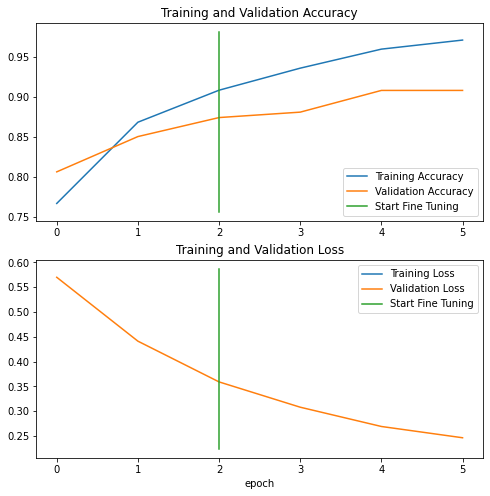

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch)

# # Apply an argmax since our model returns softmax
# predictions = tf.math.argmax(predictions, axis=1)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

In [ ]:
predicted_labels = model.predict(X_test)

In [ ]:
predicted_labels = [np.argmax(i) for i in predicted_labels]

In [ ]:
or_labels =[np.argmax(i) for i in y_test]

In [ ]:
conf_mat = confusion_matrix(or_labels, predicted_labels)
report = classification_report(or_labels, predicted_labels)

print('Confusion Matrix ==>')
print(conf_mat)
print('----------------------------------------------------------------------------------------')
print('Classification Report ==>')
print(report)

Confusion Matrix ==>
[[78  4  1  1]
 [11 81  0  4]
 [ 2  1 48  0]
 [ 1  1  0 94]]
----------------------------------------------------------------------------------------
Classification Report ==>
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        84
           1       0.93      0.84      0.89        96
           2       0.98      0.94      0.96        51
           3       0.95      0.98      0.96        96

    accuracy                           0.92       327
   macro avg       0.93      0.92      0.92       327
weighted avg       0.92      0.92      0.92       327



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

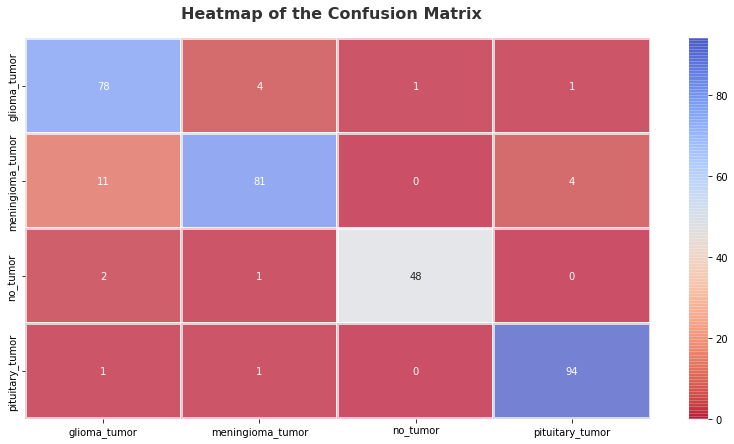

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(or_labels, predicted_labels),ax=ax,xticklabels=test_dataset.class_names,
            yticklabels=labels,annot=True, 
            cmap="coolwarm_r",alpha=0.7,linewidths=2)

           
fig.text(s='Heatmap of the Confusion Matrix',size=16,fontweight='bold',
             y=0.92,x=0.28,alpha=0.8)

#Augmentation

In [ ]:
labels=['glioma_tumor',  'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
X_train_aug = []
y_train_aug = []
image_size = 224
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 155.09it/s]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1907,shuffle=True)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=1907,shuffle=True)

In [ ]:
len(y_train)

2378

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)



In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.01),
])

In [ ]:
# צריך לשים תמונה לאחק שינוי לX_TRAIN
# for image, _ in train_dataset.take(3):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Create the base model from the pre-trained model EfficientNetB4
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1792)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
n_classes = 4
prediction_layer = tf.keras.layers.Dense(n_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 7172      
                                                           

In [ ]:
y_val.shape


(265, 4)

In [ ]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(X_val, y_val) #, batch_size=32, epochs=1,validation_data=(X_test,y_test),shuffle=False,verbose=2)

9/9 [==============================] - 6s 221ms/step - loss: 1.3433 - accuracy: 0.3132


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.34
initial accuracy: 0.31


In [ ]:
history = model.fit(X_train,y_train,
                    epochs=initial_epochs,
                    validation_data=(X_val, y_val))

Epoch 1/3
75/75 [==============================] - 22s 166ms/step - loss: 1.2641 - accuracy: 0.4096 - val_loss: 1.1685 - val_accuracy: 0.5132
Epoch 2/3
75/75 [==============================] - 13s 167ms/step - loss: 1.1174 - accuracy: 0.5563 - val_loss: 1.0608 - val_accuracy: 0.5849
Epoch 3/3
75/75 [==============================] - 13s 170ms/step - loss: 1.0129 - accuracy: 0.6043 - val_loss: 0.9879 - val_accuracy: 0.6151


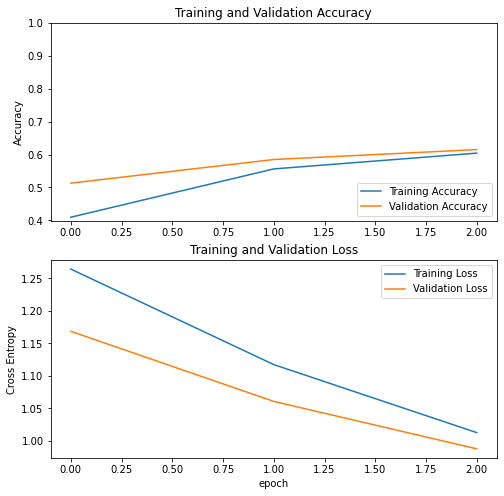

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10 #100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  474


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 7172      
                                                           

In [ ]:
fine_tune_epochs = 2 #10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train,y_train,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=(X_val, y_val))


Epoch 3/5
75/75 [==============================] - 86s 806ms/step - loss: 0.6973 - accuracy: 0.7553 - val_loss: 0.5739 - val_accuracy: 0.8151
Epoch 4/5
75/75 [==============================] - 57s 756ms/step - loss: 0.4355 - accuracy: 0.8537 - val_loss: 0.4649 - val_accuracy: 0.8189
Epoch 5/5
75/75 [==============================] - 57s 755ms/step - loss: 0.3064 - accuracy: 0.8966 - val_loss: 0.3954 - val_accuracy: 0.8679


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test accuracy :', accuracy)

11/11 [==============================] - 2s 141ms/step - loss: 0.3794 - accuracy: 0.8777
Test accuracy : 0.8776758313179016


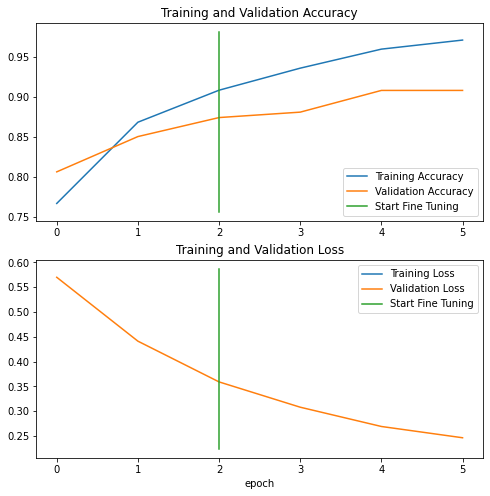

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch)

# # Apply an argmax since our model returns softmax
# predictions = tf.math.argmax(predictions, axis=1)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

#Confusion matrix

In [ ]:
predicted_labels = model.predict(X_test)

In [ ]:
predicted_labels = [np.argmax(i) for i in predicted_labels]

In [ ]:
or_labels =[np.argmax(i) for i in y_test]

In [ ]:
conf_mat = confusion_matrix(or_labels, predicted_labels)
report = classification_report(or_labels, predicted_labels)

print('Confusion Matrix ==>')
print(conf_mat)
print('----------------------------------------------------------------------------------------')
print('Classification Report ==>')
print(report)

Confusion Matrix ==>
[[78  4  1  1]
 [11 81  0  4]
 [ 2  1 48  0]
 [ 1  1  0 94]]
----------------------------------------------------------------------------------------
Classification Report ==>
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        84
           1       0.93      0.84      0.89        96
           2       0.98      0.94      0.96        51
           3       0.95      0.98      0.96        96

    accuracy                           0.92       327
   macro avg       0.93      0.92      0.92       327
weighted avg       0.92      0.92      0.92       327



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

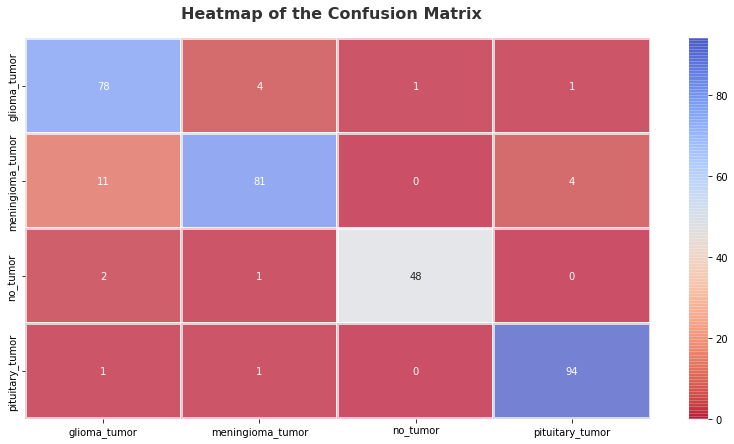

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(or_labels, predicted_labels),ax=ax,xticklabels=test_dataset.class_names,
            yticklabels=labels,annot=True, 
            cmap="coolwarm_r",alpha=0.7,linewidths=2)

           
fig.text(s='Heatmap of the Confusion Matrix',size=16,fontweight='bold',
             y=0.92,x=0.28,alpha=0.8)